In [ ]:
from loguru import logger
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [74]:
try:
    data = pl.read_csv("exercise_21.csv")
except Exception as e:
    logger.error(e)
    data = pd.read_stata("exercise_21.dta")
    data = pl.DataFrame(data[["state", "party4"]])
    data.write_csv("exercise_21.csv")

data.head()

state,party4
str,str
"""massachusetts""","""democrat"""
"""massachusetts""","""republican"""
"""massachusetts""","""independent"""
"""massachusetts""","""independent"""
"""massachusetts""","""democrat"""


In [ ]:
data = (
    data.group_by(["state", "party4"])
    .len()
    .pivot("party4", index="state", values="len", aggregate_function="sum")
    .fill_null(0)
    .with_columns((pl.col("independent") + pl.col("null")).alias("other"))
    .drop("null")
    .with_columns(
        (
            pl.col(r"other\no preference\dk\refused")
            + pl.col("republican")
            + pl.col("democrat")
            + pl.col("independent")
        ).alias("total")
    )
    .filter(~pl.col("state").is_in(["alaska", "hawaii", "washington dc"]))
)

data.head()

state,democrat,other\no preference\dk\refused,republican,independent,other,total
str,u32,u32,u32,u32,u32,u32
"""colorado""",156,23,155,131,134,465
"""kansas""",98,11,97,119,123,325
"""new york""",705,111,354,496,531,1666
"""vermont""",25,5,25,59,60,114
"""florida""",564,85,585,483,513,1717


**Model:**
- let $n_j$ be the survey sample size in state $j$
- let $y_j$ be the number of people identifying as democrats in state $j$
- let $\theta_j$ be the proportion of democrats in state $j$
- then we have:
$$
\begin{align}
\alpha & \sim \text{HalfNormal}(6) \\ 
\beta & \sim \text{HalfNormal}(10) \\
\theta_j & \sim \text{Beta}(\alpha, \beta) \\
y_j & \sim \text{Binomial} ( n_j , \theta_j )
\end{align}
$$
where $\alpha$ and $\beta$ are the hyperpriors 

In [134]:
coords = {"states": data["state"].to_list()}

with pm.Model(coords=coords) as model:
    alpha = pm.HalfNormal("alpha", sigma=10.0)
    beta = pm.HalfNormal("beta", sigma=12.0)
    theta = pm.Beta("theta", alpha=alpha, beta=beta, dims="states")

    democrats = pm.Binomial(
        "democrats",
        n=data["total"].to_list(),
        p=theta,
        dims="states",
        observed=data["democrat"].to_list(),
    )

    trace = pm.sample(2000, tune=1000)
    prior = pm.sample_prior_predictive(500)
    posterior = pm.sample_posterior_predictive(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Sampling: [alpha, beta, democrats, theta]
Sampling: [democrats]


Output()

In [136]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,12.459,2.439,7.909,17.019,0.038,0.026,4099.0,4030.0,1.0
beta,25.915,5.014,16.712,35.364,0.076,0.054,4302.0,4411.0,1.0
theta[colorado],0.335,0.021,0.297,0.374,0.000,0.000,11380.0,6437.0,1.0
theta[kansas],0.304,0.024,0.257,0.346,0.000,0.000,10012.0,5493.0,1.0
theta[new york],0.421,0.012,0.399,0.443,0.000,0.000,10166.0,5891.0,1.0
theta[vermont],0.245,0.035,0.183,0.312,0.000,0.000,9220.0,5791.0,1.0
theta[florida],0.329,0.011,0.308,0.349,0.000,0.000,11068.0,6513.0,1.0
theta[delaware],0.339,0.038,0.272,0.414,0.000,0.000,10803.0,6152.0,1.0
theta[maryland],0.452,0.020,0.414,0.488,0.000,0.000,12846.0,5800.0,1.0
theta[georgia],0.342,0.015,0.314,0.370,0.000,0.000,12199.0,5884.0,1.0


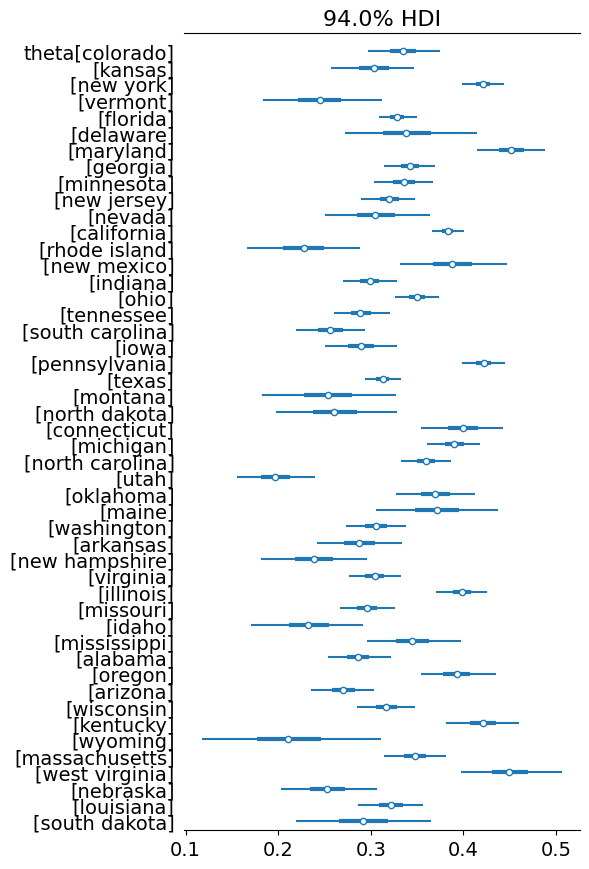

In [137]:
az.plot_forest(trace, var_names="theta", combined=True)
plt.tight_layout()
plt.show()

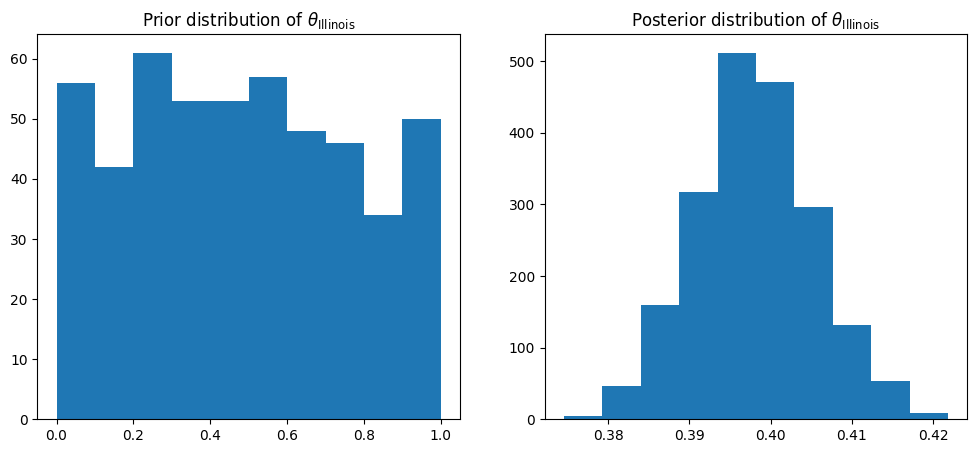

In [138]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(prior.prior["theta"].loc[:, :, "illinois"].mean("chain"))
ax2.hist(trace.posterior["theta"].loc[:, :, "illinois"].mean("chain"))

ax1.set_title(r"Prior distribution of $\theta_{\text{Illinois}}$")
ax2.set_title(r"Posterior distribution of $\theta_{\text{Illinois}}$")
plt.show()

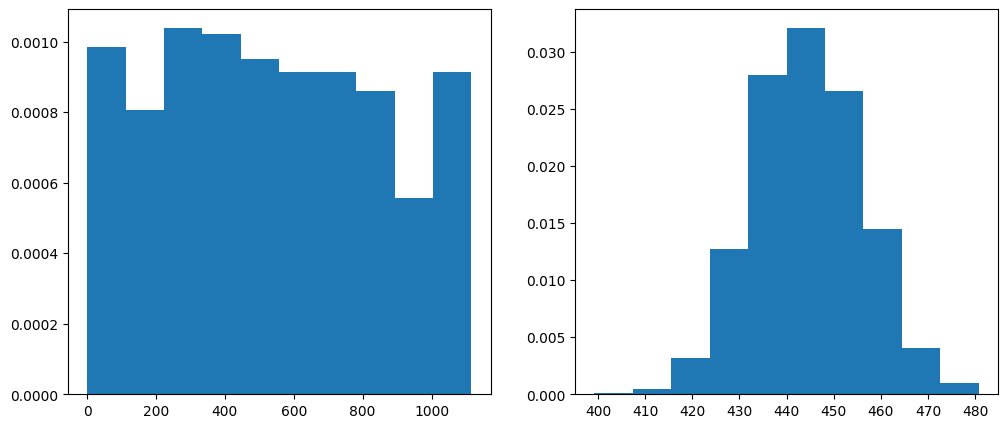

In [139]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(
    prior.prior_predictive["democrats"].loc[:, :, "illinois"].mean("chain"),
    density=True,
)

ax2.hist(
    posterior.posterior_predictive["democrats"].loc[:, :, "illinois"].mean("chain"),
    density=True,
)

plt.show()